#The Bias in News Coverage on the Ukrainian-Russian War

*Team: Tiffany Lee, Isaiah Muray, Chenran Ning, Anastasia Sorokina*

Created by Chenran Ning (cn257@cornell.edu)

Read the full article from [here](https://medium.com/@ansorokina163/a-quantitative-analysis-of-the-bias-in-news-coverage-on-the-ukrainian-russian-war-ceffd5842f37).

This is a coure project for INFO 5330 Technology, Media, and Democracy (2022SP) at Cornell Tech to understand information ecosystem.

This part is to analyze web-scraped datas. 

The study analyzes the bias in news coverage on the Ukrainian-Russian War between the United States and Russia using natural language processing (NLP) in English and Russian languages. The aim is to understand the narrative discrepancies in news coverage and invoke a collective consciousness on the need for truthful news coverage across the world in times of humanitarian crises. 

We used four types of natural language models for sentiment analysis, named entity recognition, topic modeling, and Policy BERT, and an English-Russian translator to process data. 

The news articles were scraped from the highest readership news outlets in Russia and the US. 

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
import os
# TODO: Put your dataset in your google drive!
os.chdir('/content/drive/MyDrive/TMD')
!ls

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
'Average score for each category.jpg'	  policy.csv
'Average score for each emotion.jpg'	  sentiment.csv
'Counts for different emotions.jpg'	 'Source in US news.jpg'
'Frequency of entities in articles.jpg'   text
 headers_sample.txt			  tmd-demo-data.csv
 ner_en.csv				  ukraine.txt


## 1. Load data

In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
from sklearn import utils
from sklearn.model_selection import train_test_split
import gensim
from sklearn.linear_model import LogisticRegression
from gensim.models.doc2vec import TaggedDocument
import re
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
nltk.download('punkt')
import time
import csv
from datetime import timedelta
!pip install transformers

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
en_path = "text/final_en.csv"
ru_path = "text/ru_w_translation.csv"

In [ ]:
def cleanText(text):
    text = BeautifulSoup(text, "lxml").text
    text = re.sub(r'\|\|\|', r' ', text) 
    text = re.sub(r'http\S+', r'<URL>', text)
    text = text.lower()
    text = text.replace('x', '')
    return text

def read_data(path):
    data = pd.read_csv(path)
    data['text'] = data['translated']
    # do not fill na
    data['text'] = data[data['text'].notna()]['text'].apply(cleanText)
    return data


In [ ]:
# data : change the path here!
data = read_data(ru_path)
data.head()

,Unnamed: 0,index,date,title,author,source,source_id,url,description,content,text,text_nopunc,text_tokenized,ner,translated
0,0,0,2022-03-25 06:29:00+00:00,Медведев оценил ход спецоперации на Украине,Анна Щербакова,Lenta,lenta,https://lenta.ru/news/2022/03/25/medvedev/,Заместитель председателя Совбеза Дмитрий Медве...,NaN,"ukraine, on the basis of the outcome of the sp...",Украина по итогам специальной операции должна ...,"['Украина', 'по', 'итогам', 'специальной', 'оп...","['Wolfgang', 'Berlin']","Ukraine, on the basis of the outcome of the sp..."
1,1,1,2022-03-25 14:13:00+00:00,Мединский назвал ключевые шаги для заключения ...,Сергей Истомин,Lenta,lenta,https://lenta.ru/news/2022/03/25/medinn/,"Без демилитаризации, денацификации Украины, а ...",NaN,"without demilitarization, denacification of uk...",Без демилитаризации денацификации Украины а та...,"['Без', 'демилитаризации', 'денацификации', 'У...","['Wolfgang', 'Berlin']","Without demilitarization, denacification of Uk..."
2,2,2,2022-03-26 21:43:00+00:00,Захарова рассказала о стремлении России развит...,Марина Совина,Lenta,lenta,https://lenta.ru/news/2022/03/27/mariaz/,Официальный представитель МИД РФ Мария Захаров...,NaN,the official representative of the ministry of...,Официальный представитель МИД РФ Мария Захаров...,"['Официальный', 'представитель', 'МИД', 'РФ', ...","['Wolfgang', 'Berlin']",The official representative of the Ministry of...
3,3,3,2022-03-25 13:20:19+00:00,Эрдоган заявил о близости России и Украины к к...,Виктория Кондратьева,Lenta,lenta,https://lenta.ru/news/2022/03/25/consensus/,"Президент Турции Реджеп Тайип Эрдоган заявил, ...",: Gonzalo Fuentes / Reuters,russia and ukraine are close to a consensus in...,Россия и Украина близки к консенсусу на перего...,"['Россия', 'и', 'Украина', 'близки', 'к', 'кон...","['Wolfgang', 'Berlin']",Russia and Ukraine are close to a consensus in...
4,4,4,2022-03-25 10:40:46+00:00,Украина предложила ЕС закрыть транспортное соо...,Георгий Нестеров,Lenta,lenta,https://lenta.ru/news/2022/03/25/blocked_eu/,Мининфраструктуры Украины предложило ЕС усилит...,NaN,the ministry of infrastructure of ukraine has ...,Министерство инфраструктуры Украины предложило...,"['Министерство', 'инфраструктуры', 'Украины', ...","['Wolfgang', 'Berlin']",The Ministry of Infrastructure of Ukraine has ...


## 2. Data explore


In [ ]:
# Show unique categories values

def categories(data, title, dropna=False, rotation=20, figsize=(8,6)):
    data = data.value_counts(dropna=dropna).to_dict()
    plt.figure(figsize=figsize)
    plt.title(title)
    plt.bar(np.arange(len(data)), list(data.values()))
    plt.xticks(np.arange(len(data)), list(data.keys()), rotation=rotation)
    plt.savefig(title+".jpg")
    plt.show()
    return data

In [ ]:
# take a look at the sources and total counts
print("There are {} articles in the dataset.\nAnd {} valid articles.".format(len(data), data['text'].notna().sum()))

There are 1522 articles in the dataset.
And 1522 valid articles.


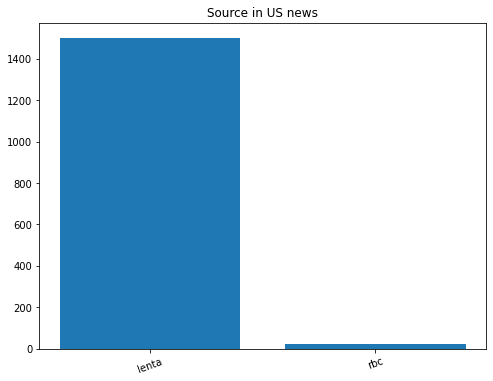

{'lenta': 1499, 'rbc': 23}


In [ ]:
sources = data['source_id']
title = "Source in US news"
sources_count = categories(sources, title)
print(sources_count)

## 3. Model building

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

# use cuda
torch.cuda.is_available()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


cuda:0


### Policy-DistilBERT

[link](https://huggingface.co/MoritzLaurer/policy-distilbert-7d)
This model will classify articles into 7 categories.
Maximium words are 512.

In [ ]:
model_name = "MoritzLaurer/policy-distilbert-7d"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
model = model.to(device)
label_names = ["external relations", "freedom and democracy", "political system", "economy", "welfare and quality of life", "fabric of society", "social groups"]
# the output corresponds to the following labels:
# 0: external relations, 1: freedom and democracy, 2: political system, 3: economy, 4: welfare and quality of life, 5: fabric of society, 6: social groups

def get_prediction(model, input):
    output = model(input)
    # output to dictionary
    prediction = torch.softmax(output["logits"][0], -1).tolist()
    # prediction = {name: round(float(pred) * 100, 1) for pred, name in zip(prediction, label_names)}
    return prediction

Downloading:   0%|          | 0.00/258 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/948 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/255M [00:00<?, ?B/s]

In [ ]:
# prepare data
en_policy = data['text'].apply(tokenizer, truncation=True, return_tensors="pt")
en_policy = en_policy.tolist()
en_policy = [x["input_ids"].to(device) for x in en_policy]

In [ ]:
# infor about dataset
print("English policy dataset:")
print(len(en_policy))
print("Example input:", en_policy[0])
print("cuda:", en_policy[0].is_cuda)
print("Example output:", get_prediction(model, en_policy[0]))

English policy dataset:
1522
Example input: tensor([[  101,  5924,  1010,  2006,  1996,  3978,  1997,  1996,  9560,  1997,
          1996,  2569,  3169,  1010,  2323,  2468,  1037,  1000,  3671, 20065,
          1000,  1997,  3607,  1012,  1999,  2019,  4357,  2007, 15544,  2050,
         24576, 21756,  1010,  3580,  1011,  2343,  2061, 26493, 28640, 22141,
         19960,  7178,  6777,  1010, 13233,  2008,  1996,  2569,  3169,  1999,
          5924,  2001,  4975,  2429,  2000,  2933,  1012,  1999,  2010,  3193,
          1010,  5924,  2323,  2036,  2468,  1037, 27668, 27606, 18425,  2110,
          2008,  2052, 17738, 17457,  3424,  1011,  2845,  3343,  1012, 23564,
         26876,  3217,  2061, 26493, 28640,  7383,  2008,  1996,  2569,  3169,
          2018,  5625,  3952,  2138,  1996, 11100,  2008,  3607,  2018,  2275,
          2005,  2993,  2018,  2025,  2042,  4719,  2083, 17610,  1012,  1000,
          2122, 11100, 14396,  2000,  1996,  2925,  1997,  5924,  1517,  1996,
        

In [ ]:
# calculate the results!
en_policy_res = []
start_time = time.time()
for i in range(len(en_policy)):
    prediction = get_prediction(model, en_policy[i])
    en_policy_res.append(prediction)
    if i % 100 == 0 and i:
        elapsed_time = time.time() - start_time
        estimated_time = elapsed_time * (len(en_policy) - i) / i
        print("Completed {} rows, estimate left time: {}".format(i, timedelta(seconds=estimated_time)))


Completed 100 rows, estimate left time: 0:00:11.521352
Completed 200 rows, estimate left time: 0:00:10.475840
Completed 300 rows, estimate left time: 0:00:09.645838
Completed 400 rows, estimate left time: 0:00:08.794394
Completed 500 rows, estimate left time: 0:00:07.950591
Completed 600 rows, estimate left time: 0:00:07.191839
Completed 700 rows, estimate left time: 0:00:06.425294
Completed 800 rows, estimate left time: 0:00:05.633201
Completed 900 rows, estimate left time: 0:00:04.839359
Completed 1000 rows, estimate left time: 0:00:04.053611
Completed 1100 rows, estimate left time: 0:00:03.278425
Completed 1200 rows, estimate left time: 0:00:02.494629
Completed 1300 rows, estimate left time: 0:00:01.717543
Completed 1400 rows, estimate left time: 0:00:00.943058
Completed 1500 rows, estimate left time: 0:00:00.169451


In [ ]:
# save file
import csv
with open('policy.csv', 'w') as f:
    write = csv.writer(f)
    write.writerow(label_names)
    write.writerows(en_policy_res)

read csv to analysis

In [ ]:
import csv
policy = pd.read_csv('policy.csv')
print(policy)

      external relations  freedom and democracy  political system   economy  \
0               0.999977               0.000003          0.000003  0.000004   
1               0.999955               0.000012          0.000010  0.000005   
2               0.981152               0.018384          0.000101  0.000011   
3               0.999977               0.000004          0.000003  0.000004   
4               0.999933               0.000018          0.000012  0.000007   
...                  ...                    ...               ...       ...   
1517            0.999975               0.000003          0.000003  0.000004   
1518            0.998351               0.000542          0.000247  0.000011   
1519            0.999812               0.000017          0.000082  0.000034   
1520            0.999973               0.000005          0.000004  0.000003   
1521            0.999977               0.000002          0.000003  0.000006   

      welfare and quality of life  fabric of societ

### Basic analysis about policy categories

In [ ]:
# lets do some basic analysis
policy = np.array(policy)
print(policy.shape)
policy = policy[list(data['text'].notna())]
print(policy.shape)

(1522, 7)
(1522, 7)


Average score for each category
external relations  :  0.7500748793447167
freedom and democracy  :  0.14114939008012856
political system  :  0.018825399458259902
economy  :  0.04771994775145149
welfare and quality of life  :  0.00858139072656512
fabric of society  :  0.026921870871414188
social groups  :  0.00672711843592976


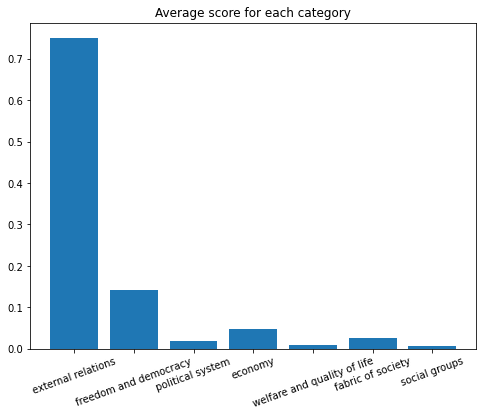

In [ ]:
avg_policy = np.average(policy, axis=0)
# print(avg_policy)
title = "Average score for each category"
print(title)
for i in range(7):
    print(label_names[i], " : ", avg_policy[i])

plt.figure(figsize=(8,6))
plt.bar(np.arange(7), avg_policy)
plt.title(title)
plt.xticks(ticks=np.arange(7), labels=label_names, rotation = 20)
plt.savefig(title+".jpg")
plt.show()


### Sentiment Analysis in English

[link](https://huggingface.co/finiteautomata/bertweet-base-sentiment-analysis)


In [ ]:
torch.cuda.is_available()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
!pip3 install emoji

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("finiteautomata/bertweet-base-sentiment-analysis")
model = AutoModelForSequenceClassification.from_pretrained("finiteautomata/bertweet-base-sentiment-analysis")
model = model.to(device)
label_names = ["Neg", "Neu", "Pos"]
def get_prediction(model, input):
    output = model(input)
    # output to dictionary
    prediction = torch.softmax(output["logits"][0], -1).tolist()
    # prediction = {name: round(float(pred) * 100, 1) for pred, name in zip(prediction, label_names)}
    return prediction

Downloading:   0%|          | 0.00/295 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/890 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/824k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.03M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/17.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/150 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/515M [00:00<?, ?B/s]

In [ ]:
# prepare data
en_senti = data['text'].apply(tokenizer, truncation=True, return_tensors="pt")
en_senti = en_senti.tolist()
en_senti = [x["input_ids"].to(device) for x in en_senti]
print(en_senti[0])

tensor([[    0,  5378,  1127,  3800,     7,    24,     6,  5746,    15,     6,
          9587,    15,     6,   985, 18190,  4359,     7,   151,   870,    11,
         61933,  1826, 61583,    26,    15,   855, 20841, 58557,    16,    74,
          2029,    30,  8822,  1469,  4139,  8688,     7, 39565,  1652,  2266,
           717,  1132,  3614,   541, 10809,  2694,  8496, 28272,  2426,     7,
          5647,    25,     6,   985,  8069,    16,  5378, 43755,    38,  9100,
          3479,     9, 12489,     4,    16,    91, 23778,     7,  5378, 43755,
           151,   237,   870,    11,  6862,  1370, 22581,  3789,   852,    25,
            86,  7427, 15806,  3617, 19640, 28444,   460,     4, 45356, 39104,
          2266,   717,  1132,  3614, 30062,    25,     6,   985,  8069,   118,
         11079, 11791,   153,     6, 37312,    25, 41324,   118,   610,    19,
          2570,   118,    46,   108,  8726,   292, 60547,  7794,   460,     4,
         61933,   198, 37312,  6506,     9,     6,  

In [ ]:
# calculate the results!
en_senti_res = []
start_time = time.time()
for i in range(len(en_senti)):
    prediction = get_prediction(model, en_senti[i])
    en_senti_res.append(prediction)
    if i % 100 == 0 and i:
        elapsed_time = time.time() - start_time
        estimated_time = elapsed_time * (len(en_senti) - i) / i
        print("Completed {} rows, estimate left time: {}".format(i, timedelta(seconds=estimated_time)))


Completed 100 rows, estimate left time: 0:00:32.484795
Completed 200 rows, estimate left time: 0:00:31.531415
Completed 300 rows, estimate left time: 0:00:28.906642
Completed 400 rows, estimate left time: 0:00:26.269245
Completed 500 rows, estimate left time: 0:00:25.002812
Completed 600 rows, estimate left time: 0:00:23.688934
Completed 700 rows, estimate left time: 0:00:20.935903
Completed 800 rows, estimate left time: 0:00:18.439511
Completed 900 rows, estimate left time: 0:00:16.108521
Completed 1000 rows, estimate left time: 0:00:13.226464
Completed 1100 rows, estimate left time: 0:00:10.663467
Completed 1200 rows, estimate left time: 0:00:07.787049
Completed 1300 rows, estimate left time: 0:00:05.163009
Completed 1400 rows, estimate left time: 0:00:02.735270
Completed 1500 rows, estimate left time: 0:00:00.477165


In [ ]:
# save file
import csv
with open('sentiment.csv', 'w') as f:
    write = csv.writer(f)
    write.writerow(label_names)
    write.writerows(en_senti_res)

In [ ]:
import csv 
senti = pd.read_csv('sentiment.csv').to_numpy()
# lets do some basic analysis
# senti = np.array(en_senti_res)
senti = senti[list(data['text'].notna())]
print(senti.shape)
senti = list(np.argmax(senti, axis=1))
senti = pd.DataFrame(senti)
senti = senti.value_counts().to_dict()
# senti = [senti[np.array((i,))] for i in range(2)]
senti = [senti[(i,)] for i in range(3)]
sum = np.sum(np.array(senti))
senti = np.array(senti) /sum
print(senti)

(1522, 3)
[0.15834428 0.83245729 0.00919842]


Pertages for different emotions
Neg  :  0.1583442838370565
Neu  :  0.8324572930354797
Pos  :  0.009198423127463863


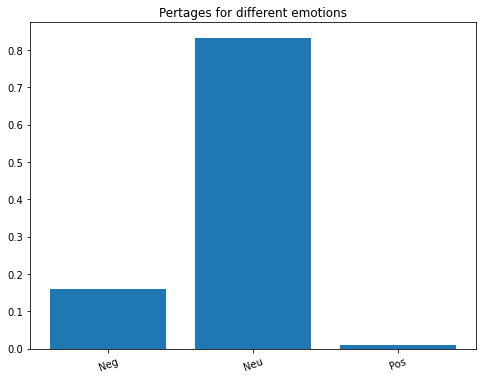

In [ ]:


# print(avg_senti)
title = "Pertages for different emotions"
print(title)
label_names = ["Neg", "Neu", "Pos"]
for i in range(len(senti)):
    print(label_names[i], " : ", senti[i])

plt.figure(figsize=(8,6))
plt.bar(np.arange(len(senti)), senti)
plt.title(title)
plt.xticks(ticks=np.arange(len(senti)), labels=label_names, rotation = 20)
plt.savefig(title+".jpg")
plt.show()



### model fine-tuned from roberta-large for NER task

[link](https://huggingface.co/Jean-Baptiste/roberta-large-ner-english)

In [ ]:
from transformers import AutoTokenizer, AutoModelForTokenClassification, pipeline
import torch
torch.cuda.is_available()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
tokenizer = AutoTokenizer.from_pretrained("Jean-Baptiste/roberta-large-ner-english")
model = AutoModelForTokenClassification.from_pretrained("Jean-Baptiste/roberta-large-ner-english")
# model = model.to(device)
label_names = ["PER", "ORG", "LOC", "MISC"]
label_indexes = {"PER": 0, "ORG": 1, "LOC": 2, "MISC": 3}

nlp = pipeline('ner', model=model, tokenizer=tokenizer, aggregation_strategy="simple", device=0)
print(nlp)
def get_prediction(text):
    res = nlp(text)
    # [index, score, word]
    res = [[label_indexes[d["entity_group"]], d["score"], d["word"]] for d in res]
    return res

In [ ]:
en_text = data[data['text'].notna()]['text']
en_text.head()
en_text = en_text.to_list()

In [ ]:
# calculate the results!
en_ner_res = []
start_time = time.time()
for i in range(len(en_text)):
    prediction = get_prediction(en_text[i])
    en_ner_res.append(prediction)
    if i % 10 == 0 and i:
        elapsed_time = time.time() - start_time
        estimated_time = elapsed_time * (len(en_text) - i) / i
        print("Completed {} rows, estimate left time: {}".format(i, timedelta(seconds=estimated_time)))

/usr/local/lib/python3.7/dist-packages/transformers/pipelines/base.py:998: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  UserWarning,


Completed 10 rows, estimate left time: 0:02:32.130458
Completed 20 rows, estimate left time: 0:02:06.339269
Completed 30 rows, estimate left time: 0:01:55.001337
Completed 40 rows, estimate left time: 0:01:50.367051
Completed 50 rows, estimate left time: 0:01:48.015105
Completed 60 rows, estimate left time: 0:01:44.037539
Completed 70 rows, estimate left time: 0:01:39.057634
Completed 80 rows, estimate left time: 0:01:36.548814
Completed 90 rows, estimate left time: 0:01:34.397206
Completed 100 rows, estimate left time: 0:01:32.957780
Completed 110 rows, estimate left time: 0:01:31.598851
Completed 120 rows, estimate left time: 0:01:30.978147
Completed 130 rows, estimate left time: 0:01:29.665874
Completed 140 rows, estimate left time: 0:01:28.252627
Completed 150 rows, estimate left time: 0:01:26.856645
Completed 160 rows, estimate left time: 0:01:26.277297
Completed 170 rows, estimate left time: 0:01:24.903832
Completed 180 rows, estimate left time: 0:01:24.620128
Completed 190 rows,

In [ ]:
# [index, score, word]
# only preserve the top score of words?

# let's do some basic analysis of these words

# show the score range
scores = [ column[1] for row in en_ner_res for column in row ]
scores = np.array(scores)
print("Score range is [{} , {}]".format(np.min(scores), np.max(scores)))

Score range is [0.30040621757507324 , 0.9999699592590332]


In [ ]:
# save files
en_text = data[data['text'].notna()]['text']
indexes = list(en_text.index)
print(indexes)
print(len(en_ner_res))

en_ner_save = []
for i in range(len(indexes)):
    for label, score, word in en_ner_res[i]:
        en_ner_save.append([indexes[i], label, score, word])
print(len(en_ner_save))
print(en_ner_save[:2])

import csv
label_names = ["index", "label", "score", "word"]
with open('ner_en.csv', 'w') as f:
    write = csv.writer(f)
    write.writerow(label_names)
    write.writerows(en_ner_save)


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,

In [ ]:
# read from files
import csv
en_ner_read = pd.read_csv('ner_en.csv')
en_ner_read.head()
en_ner_read = en_ner_read.values.tolist()
tmp = {}
for index, label, score, word in en_ner_read:
    if tmp.get(index):
        tmp[index].append([label, score, word])
    else:
        tmp[index] = [[label, score, word]]
# change into dataframe
# print(list(tmp.values()))
en_ner_values = list(tmp.values())
en_ner_indexes = list(tmp.keys())

In [ ]:
print(len(en_ner_read))

68804


In [ ]:
label_names = ["PER", "ORG", "LOC", "MISC"]
label_indexes = {"PER": 0, "ORG": 1, "LOC": 2, "MISC": 3}

# calculated label
def words_label(data, index):
    words = {}
    for row in data:
        for i, score, word in row:
            if index == i:
                words[word] = words.get(word, 0) + score
    words = {k: v for k, v in sorted(words.items(), key=lambda item: -item[1])}
    # cleaning
    key_words = list(words.keys())
    delete_words = ['.', ' u', '�']
    for d in delete_words:
        if d in key_words:
            key_words.remove(d)
    top50 = key_words[:20]
    top50_scores = [words[word] for word in top50]
    return top50, top50_scores

def show_words(title, top50, top50_scores):
    print(title)
    plt.figure(figsize=(8,6))
    plt.bar(np.arange(20), top50_scores)
    plt.title(title)
    plt.xticks(ticks=np.arange(20), labels=top50, rotation = 90)
    plt.savefig(title+".jpg")
    plt.show()

title = "Frequency of entities in articles"

Frequency of PER in USA articles


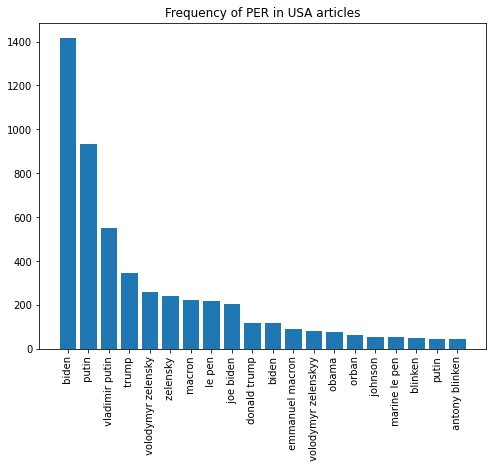

Frequency of ORG in USA articles


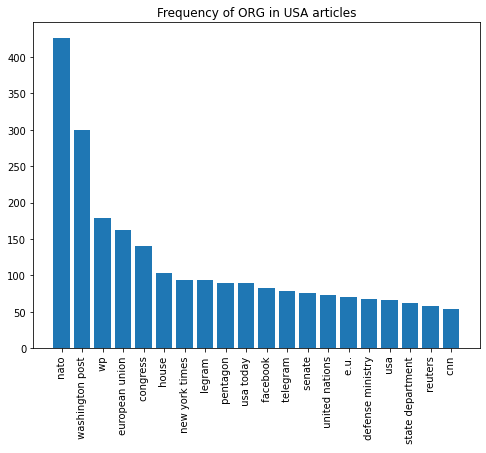

Frequency of LOC in USA articles


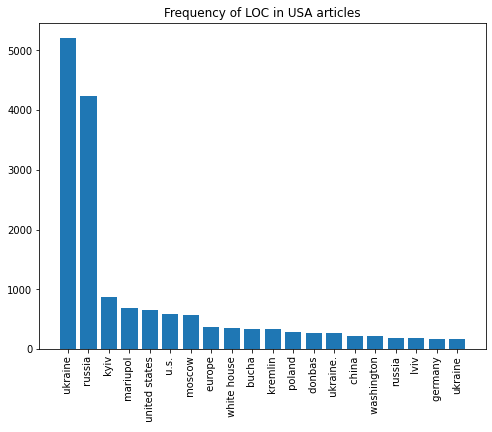

Frequency of MISC in USA articles


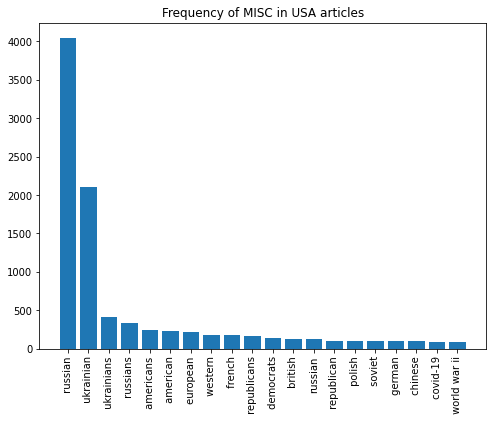

In [ ]:
for i in range(len(label_names)):
    top50, top50_scores = words_label(en_ner_values, i)
    title = "Frequency of " + label_names[i] + " in USA articles"
    show_words(title, top50, top50_scores)

## Conclusion

The study found that US news coverage on the topic is more neutral compared to Russian news coverage, which tends to skew towards external relations. US news coverage focuses more on humanitarian assistance and military support, while Russian news outlets mostly talk about negotiations and sanctions. The study also addresses challenges in research approach and technical implementation and suggests future work on understanding the media response to current events and how this shapes public perception and their response to humanitarian crises. The study raises emergent research questions on the impact of news bias and disinformation on the media ecosystem and how multilingualism shapes views of the media ecosystem.

Read the full article [here](https://medium.com/@ansorokina163/a-quantitative-analysis-of-the-bias-in-news-coverage-on-the-ukrainian-russian-war-ceffd5842f37).